# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [1]:
import numpy as np
# Replace numdifftools with JAX:
# import numdifftools as nd
# ---------------------------------
# N.B.:
# Required: conda install -c conda-forge jax jaxlib
# ---------------------------------
import jax.numpy as jnp
from jax import grad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning

In [2]:
def simulated_annealing_tuning(x0, T0, sigma, f, n_iter = 2e5, thinning = 1):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma 
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Calculate size of the output array after thinning
    # (thinning -> save states at regular intervals instead of every iteration) 
    # Thinning is by defaut 1, and size_out = n_iter
    size_out = int((n_iter + thinning -1)//thinning)    # equivalent to ceiling (n_iter/thinning)
    v = np.zeros((size_out, n_params))
    # Store the initial parameter array
    v[0,:] = x

    iter_counter = 0
    iter_counter_thin = 0
    print("Initial loss:", f(x))
    #start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        #Metropolis accept/reject step 
        if np.exp(-np.clip(DeltaE, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter/n_iter)
        # Keep track of accepted state
        if iter_counter%1 == 0:
            print("Iteration", iter_counter, " - Temperature:", T, "Loss", f(x))
        if iter_counter%thinning == 0:
            v[iter_counter_thin,:] = x
            iter_counter_thin += 1
    
    return v
    

### SA function for final optimization

In [3]:
def simulated_annealing_optim(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized
    
    # means and covariance matrix for the jump distribution -> multivariate normal
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100,100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1-iter_counter/n_iter)
        # keep track of the algorithm state
        if iter_counter%10 == 0:
            print("Iteration ", iter_counter, " - Temperature:", T, " - Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter-int(burn_in)-1, :] = x

    return v 

# Load data

In [4]:
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [5]:
data.shape

(39220, 2)

In [6]:
data

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

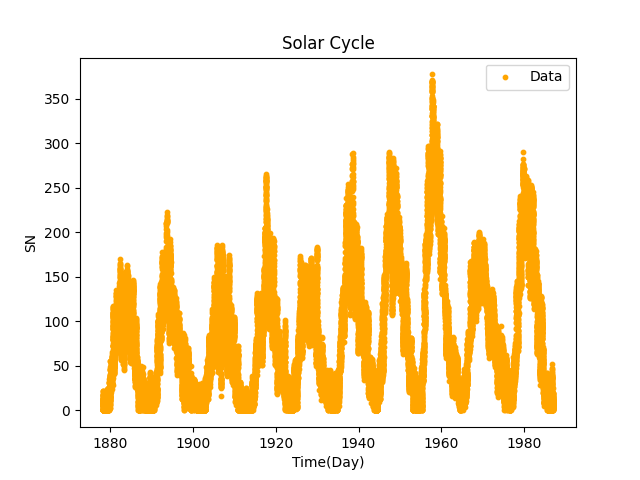

In [7]:
#Plot data for visualization
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [8]:
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


# Model and Loss Function

### Model

In [51]:
# parameters 
# Phase 1: T01, Ts1, Td1
# Phase 2: T02, Ts2, Td2 
#...
# Phase 10: T010, Ts10, Td10 
# x0 = np.array([Ts1, Td1, Ts2, Td2, ...])

x0 = np.array([0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5, 0.3, 5])

In [40]:
# The different parameters can be extracted as follows:
Ts = x0[::2]
Td = x0[1::2]

print(Ts)
print(Td)

# Number of phases
num_phases = len(Ts)
num_phases

[0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


10

In [46]:
# make TO array
T0array = np.array([1878, 1889, 1900, 1911, 1922, 1933, 1944, 1955, 1966, 1977, 1988])
# Create list of time intervals for each phase
intervals = [(float(T0array[ix]),float(T0array[ix+1])) for ix in range(num_phases)]

print(intervals)

[(1878.0, 1889.0), (1889.0, 1900.0), (1900.0, 1911.0), (1911.0, 1922.0), (1922.0, 1933.0), (1933.0, 1944.0), (1944.0, 1955.0), (1955.0, 1966.0), (1966.0, 1977.0), (1977.0, 1988.0)]


In [47]:
# We will use a loop to process all phases
for ix, (a, b) in enumerate(intervals):
    print("Processing phase", ix+1, "with interval (", a, ",", b, ")")

Processing phase 1 with interval ( 1878.0 , 1889.0 )
Processing phase 2 with interval ( 1889.0 , 1900.0 )
Processing phase 3 with interval ( 1900.0 , 1911.0 )
Processing phase 4 with interval ( 1911.0 , 1922.0 )
Processing phase 5 with interval ( 1922.0 , 1933.0 )
Processing phase 6 with interval ( 1933.0 , 1944.0 )
Processing phase 7 with interval ( 1944.0 , 1955.0 )
Processing phase 8 with interval ( 1955.0 , 1966.0 )
Processing phase 9 with interval ( 1966.0 , 1977.0 )
Processing phase 10 with interval ( 1977.0 , 1988.0 )


In [52]:
# Model for multiple phases:
def model(t, x):
    Ts = x[::2]
    Td = x[1::2]
    num_phases = len(T0array)
    intervals = [(T0array[ix],T0array[ix+1]) for ix in range(num_phases-1)]
    #Ensure t is treated as an array for consistency
    t = np.atleast_1d(t)
    model_output = np.zeros_like(t)
    for ix, (a,b) in enumerate(intervals):
        # Create mask for current phase
        mask = (a <= t) & (t < b)
        # Apply model for current phase
        model_output[mask] = ((t[mask] - T0array[ix])/Ts[ix])**2 * np.exp(-((t[mask] - T0array[ix])/Td[ix])**2)
    if model_output.size == 1:
        return model_output.item()
    else:
        return model_output


### Loss function

In [49]:
# Loss function
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

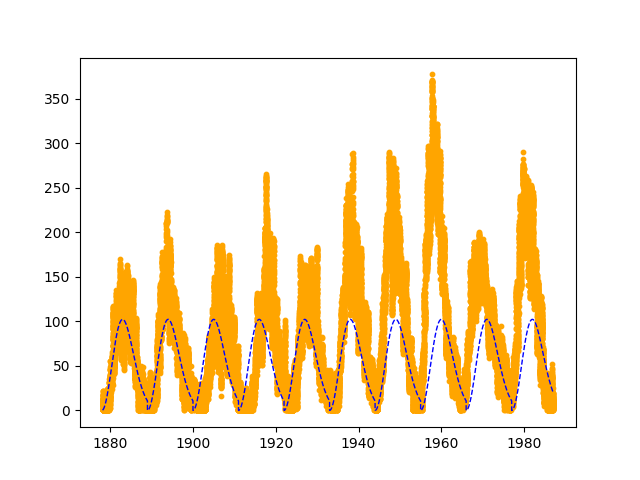

np.float64(3822.071123081075)

In [53]:
# Visualisation
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10)
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1)
plt.show(block=False)

# Initial mse:
mse(x0)

# Hyper-parameters tuning

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 0.999 Loss 3822.071123081075
Iteration 2  - Temperature: 0.998 Loss 3822.071123081075
Iteration 3  - Temperature: 0.997 Loss 3822.071123081075
Iteration 4  - Temperature: 0.996 Loss 3822.071123081075
Iteration 5  - Temperature: 0.995 Loss 3822.071123081075
Iteration 6  - Temperature: 0.994 Loss 3822.071123081075
Iteration 7  - Temperature: 0.993 Loss 3822.071123081075
Iteration 8  - Temperature: 0.992 Loss 3822.071123081075
Iteration 9  - Temperature: 0.991 Loss 3822.071123081075
Iteration 10  - Temperature: 0.99 Loss 3822.071123081075
Iteration 11  - Temperature: 0.989 Loss 3822.071123081075
Iteration 12  - Temperature: 0.988 Loss 3822.071123081075
Iteration 13  - Temperature: 0.987 Loss 3822.071123081075
Iteration 14  - Temperature: 0.986 Loss 3822.071123081075
Iteration 15  - Temperature: 0.985 Loss 3822.071123081075
Iteration 16  - Temperature: 0.984 Loss 3822.071123081075
Iteration 17  - Temperature: 0.983 Loss 3822.07112

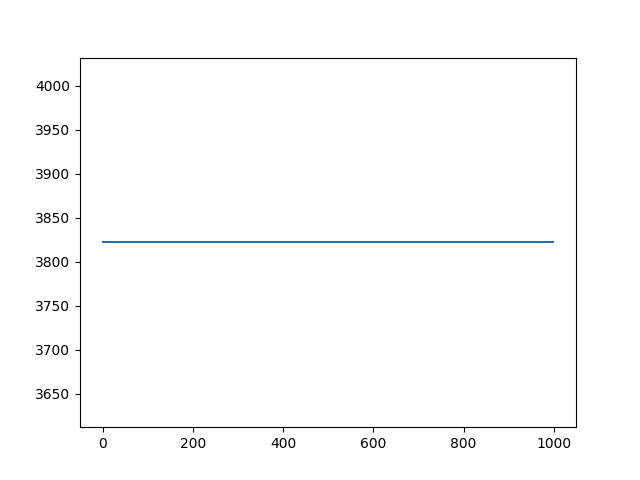

np.float64(3822.071123081075)

In [54]:
T0 = 1
sigma = 1
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 0.999 Loss 3822.071123081075
Iteration 2  - Temperature: 0.998 Loss 3822.071123081075
Iteration 3  - Temperature: 0.997 Loss 3822.071123081075
Iteration 4  - Temperature: 0.996 Loss 3822.071123081075
Iteration 5  - Temperature: 0.995 Loss 3822.071123081075
Iteration 6  - Temperature: 0.994 Loss 3822.071123081075
Iteration 7  - Temperature: 0.993 Loss 3822.071123081075
Iteration 8  - Temperature: 0.992 Loss 3822.071123081075
Iteration 9  - Temperature: 0.991 Loss 3822.071123081075
Iteration 10  - Temperature: 0.99 Loss 3822.071123081075
Iteration 11  - Temperature: 0.989 Loss 3822.071123081075
Iteration 12  - Temperature: 0.988 Loss 3822.071123081075
Iteration 13  - Temperature: 0.987 Loss 3822.071123081075
Iteration 14  - Temperature: 0.986 Loss 3822.071123081075
Iteration 15  - Temperature: 0.985 Loss 3822.071123081075
Iteration 16  - Temperature: 0.984 Loss 3822.071123081075
Iteration 17  - Temperature: 0.983 Loss 3822.07112

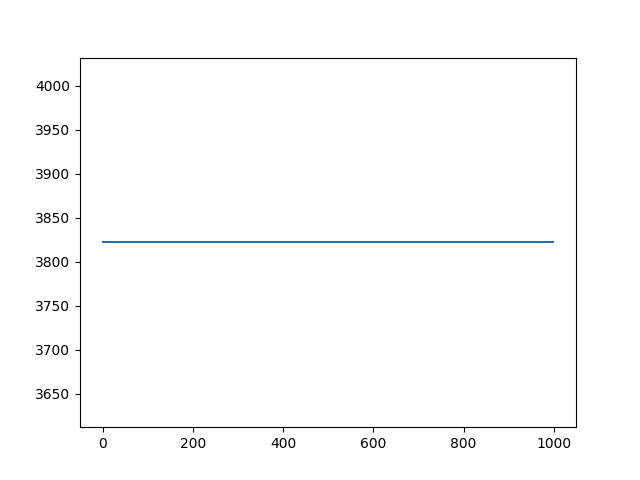

np.float64(3822.071123081075)

In [55]:
T0 = 1
sigma = 0.1
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 0.999 Loss 3822.071123081075
Iteration 2  - Temperature: 0.998 Loss 3822.071123081075
Iteration 3  - Temperature: 0.997 Loss 3822.071123081075
Iteration 4  - Temperature: 0.996 Loss 3822.071123081075
Iteration 5  - Temperature: 0.995 Loss 3822.071123081075
Iteration 6  - Temperature: 0.994 Loss 3822.071123081075
Iteration 7  - Temperature: 0.993 Loss 3667.53589464321
Iteration 8  - Temperature: 0.992 Loss 3667.53589464321
Iteration 9  - Temperature: 0.991 Loss 3667.53589464321
Iteration 10  - Temperature: 0.99 Loss 3667.53589464321
Iteration 11  - Temperature: 0.989 Loss 3667.53589464321
Iteration 12  - Temperature: 0.988 Loss 3667.53589464321
Iteration 13  - Temperature: 0.987 Loss 3667.53589464321
Iteration 14  - Temperature: 0.986 Loss 3667.53589464321
Iteration 15  - Temperature: 0.985 Loss 3667.53589464321
Iteration 16  - Temperature: 0.984 Loss 3667.53589464321
Iteration 17  - Temperature: 0.983 Loss 3667.53589464321
Ite

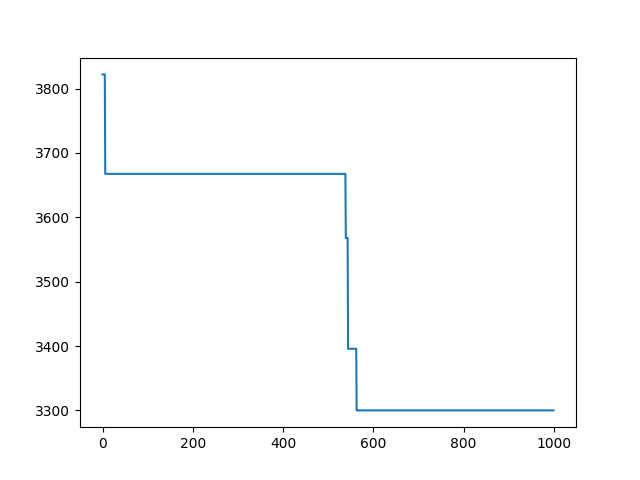

np.float64(3300.090260253215)

In [56]:
T0 = 1
sigma = 0.01
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 0.999 Loss 3822.071123081075
Iteration 2  - Temperature: 0.998 Loss 3822.071123081075
Iteration 3  - Temperature: 0.997 Loss 3822.071123081075
Iteration 4  - Temperature: 0.996 Loss 3761.415550383559
Iteration 5  - Temperature: 0.995 Loss 3761.415550383559
Iteration 6  - Temperature: 0.994 Loss 3746.3884834689475
Iteration 7  - Temperature: 0.993 Loss 3746.3884834689475
Iteration 8  - Temperature: 0.992 Loss 3746.3884834689475
Iteration 9  - Temperature: 0.991 Loss 3727.905015725505
Iteration 10  - Temperature: 0.99 Loss 3725.950249463405
Iteration 11  - Temperature: 0.989 Loss 3725.950249463405
Iteration 12  - Temperature: 0.988 Loss 3725.950249463405
Iteration 13  - Temperature: 0.987 Loss 3725.950249463405
Iteration 14  - Temperature: 0.986 Loss 3701.256891452313
Iteration 15  - Temperature: 0.985 Loss 3701.256891452313
Iteration 16  - Temperature: 0.984 Loss 3691.548340398868
Iteration 17  - Temperature: 0.983 Loss 3602.36

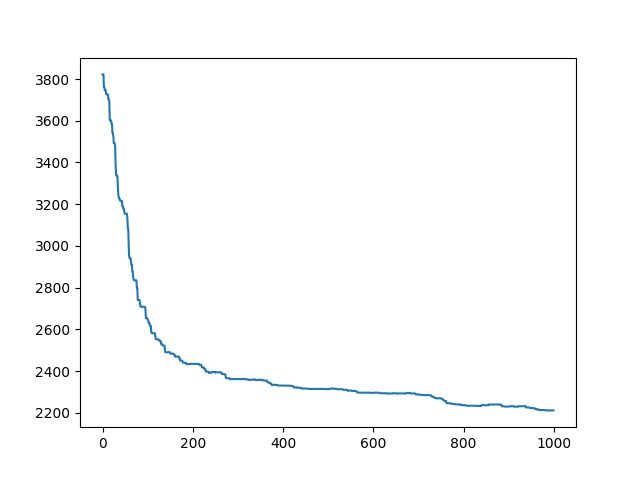

np.float64(2212.2006045808507)

In [57]:
T0 = 1
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 9.99 Loss 3822.071123081075
Iteration 2  - Temperature: 9.98 Loss 3775.890744047483
Iteration 3  - Temperature: 9.97 Loss 3775.890744047483
Iteration 4  - Temperature: 9.96 Loss 3764.1472327656456
Iteration 5  - Temperature: 9.95 Loss 3758.0921479222657
Iteration 6  - Temperature: 9.94 Loss 3745.4707930408613
Iteration 7  - Temperature: 9.93 Loss 3737.417151101954
Iteration 8  - Temperature: 9.92 Loss 3731.029329707606
Iteration 9  - Temperature: 9.91 Loss 3670.1206519966895
Iteration 10  - Temperature: 9.9 Loss 3643.0893664043438
Iteration 11  - Temperature: 9.89 Loss 3630.1443215016925
Iteration 12  - Temperature: 9.879999999999999 Loss 3599.618795625793
Iteration 13  - Temperature: 9.87 Loss 3592.8115896325553
Iteration 14  - Temperature: 9.86 Loss 3582.8893847879017
Iteration 15  - Temperature: 9.85 Loss 3582.8893847879017
Iteration 16  - Temperature: 9.84 Loss 3551.3092420394196
Iteration 17  - Temperature: 9.83 Loss 3510

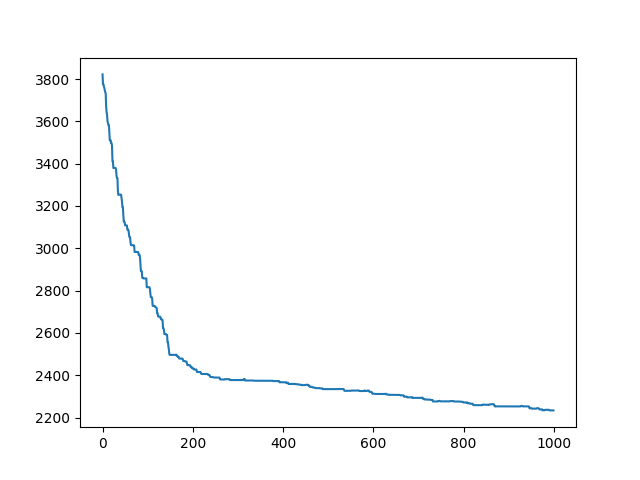

np.float64(2233.7885048377693)

In [58]:
T0 = 10
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 0.4995 Loss 3761.8624060930333
Iteration 2  - Temperature: 0.499 Loss 3740.0919632799905
Iteration 3  - Temperature: 0.4985 Loss 3740.0919632799905
Iteration 4  - Temperature: 0.498 Loss 3740.0919632799905
Iteration 5  - Temperature: 0.4975 Loss 3740.0919632799905
Iteration 6  - Temperature: 0.497 Loss 3718.484957381179
Iteration 7  - Temperature: 0.4965 Loss 3696.521717459595
Iteration 8  - Temperature: 0.496 Loss 3675.3494661305667
Iteration 9  - Temperature: 0.4955 Loss 3653.003432516589
Iteration 10  - Temperature: 0.495 Loss 3653.003432516589
Iteration 11  - Temperature: 0.4945 Loss 3653.003432516589
Iteration 12  - Temperature: 0.494 Loss 3653.003432516589
Iteration 13  - Temperature: 0.4935 Loss 3653.003432516589
Iteration 14  - Temperature: 0.493 Loss 3637.6581050126174
Iteration 15  - Temperature: 0.4925 Loss 3637.6581050126174
Iteration 16  - Temperature: 0.492 Loss 3637.6581050126174
Iteration 17  - Temperature: 0.4

C:\Users\yejih\AppData\Local\Temp\ipykernel_28400\20709856.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


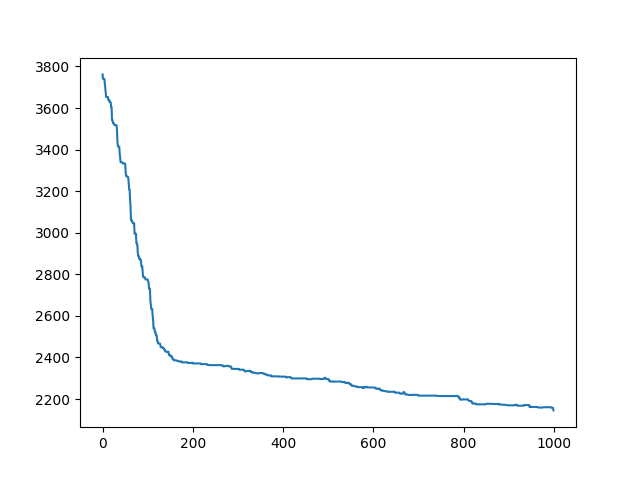

np.float64(2145.4498826658037)

In [59]:
T0 = 0.5
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Initial loss: 3822.071123081075
Iteration 1  - Temperature: 0.1998 Loss 3808.931616682579
Iteration 2  - Temperature: 0.1996 Loss 3746.343574505166
Iteration 3  - Temperature: 0.19940000000000002 Loss 3746.343574505166
Iteration 4  - Temperature: 0.19920000000000002 Loss 3746.343574505166
Iteration 5  - Temperature: 0.199 Loss 3746.343574505166
Iteration 6  - Temperature: 0.1988 Loss 3746.343574505166
Iteration 7  - Temperature: 0.1986 Loss 3730.4441368626763
Iteration 8  - Temperature: 0.19840000000000002 Loss 3727.017871848821
Iteration 9  - Temperature: 0.19820000000000002 Loss 3705.1694702939703
Iteration 10  - Temperature: 0.198 Loss 3705.1694702939703
Iteration 11  - Temperature: 0.1978 Loss 3705.1694702939703
Iteration 12  - Temperature: 0.1976 Loss 3689.1388102954165
Iteration 13  - Temperature: 0.19740000000000002 Loss 3677.4094969742378
Iteration 14  - Temperature: 0.19720000000000001 Loss 3677.4094969742378
Iteration 15  - Temperature: 0.197 Loss 3602.4551464841707
Iteration

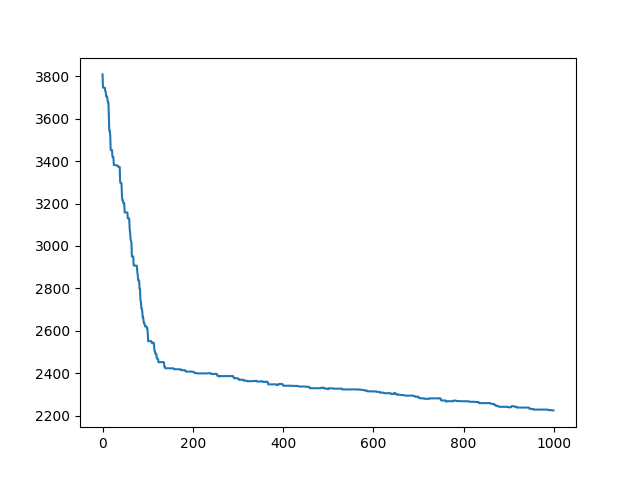

np.float64(2224.680064623032)

In [60]:
T0 = 0.2
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Optimal hyper-parameter values are :<br>
T0 = <br>
sigma = <br>

In [ ]:
# Check the final state of the tuning process

plt.figure()
plt.scatter(time_points, data_points, color='oragne', s=20)
plt.plot(time_points, model(time_points, outSA[-1]), color='blue')
plt.show(block=False)

# Final optimization

In [ ]:
#initial condition
x0_from_tuning = outSA[-1]

# Number of chains for final optimization
n_chains = 10
# Perturb the initial condition for each chain
x0noisy = np.abs(x0_from_tuning + np.random.normal(0, np.tile(np.array([0.01, 1, 0.0005]), 3), (n_chains, 9))) # abs avoids negative numbers

T0 = 0.2
sigma = 1e-5

n_iter = 1500
burn_in = 1000

In [ ]:
results = np.empty((int(n_chains*(n_iter - burn_in)),9))

for ix in range(n_chains):

    opt = simulated_annealing_ optim(x0noisy[ix], T0, sigma, mse, burn_in = burn_in, n_iter = n_iter)
    start_idx = ix * opt.shape[0]
    end_idx = start_idx + opt.shape[0]
    # write the 'opt' output directly into the allocated array
    results[start_idx : end_idx, :] = opt
    

In [ ]:
results

In [ ]:
n_params = 9

In [ ]:
center_of_mass = np.zeros(n_params)
for ix in range(n_params):
    counts, bin_edges = np.histogram(chain[:,ix], bins=20)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Calculate the center of mass
   # Weights are the counts of each bin
    center_of_mass[ix] = np.sum(counts * bin_centers) / np.sum(counts)

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, color ='orange', s=10)
plt.plot(time_points, model(time_points, *params), color='blue')
plt.show(block=False)

In [ ]:
center_of_mass

In [ ]:
#correct manually for the first time-point
center_of_mass[0] = 0

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, color ='orange', s=10)
plt.plot(time_points, model(time_points, *params), color='blue')
plt.show(block=False)